In [1]:
import clip
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json 
import sys 
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.insert(0, os.path.dirname(os.getcwd()))
import loaders
from utils import scores as sc
from utils import evaluation as ev

In [2]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
import logging
# Set Logger
logger = logging.getLogger('notebook_logger')
logger.setLevel(logging.DEBUG)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

# Define Data Loader

In [4]:
# Showing one example
# TODO: Add VSNR for cosine similarity
data_loader = loaders.DataLoader(data_source = "qa", logger=logger)
df_table = data_loader.load_dialogue_df()

#k = 5
#data_loader.showing_example(k)
#data_loader.show_clip_similarity(k, df_table, model, preprocess)

# Define OOD Categories below

In [28]:
import gensim.downloader as api
model = api.load("word2vec-google-news-300")

In [ ]:
new_supercategories = ['person',
 'animal',
 'vehicle',
 'city',
 'fashion',
 'sports',
 'tableware',
 'food',
 'furniture',
 'electronic',
 'appliance',
 'indoor'
]

In [ ]:
for category_a in new_supercategories:
    cosine_sim_current = 0
    for category_b in new_supercategories:
        text_tokens_a = model[category_a]
        text_tokens_b = model[category_b]
        cosine_sim_current += np.dot(text_tokens_a, text_tokens_b) / (np.linalg.norm(text_tokens_a) * np.linalg.norm(text_tokens_b))
    print(f"Cosine similarity for {category_a} is: {cosine_sim_current - 1}")

In [5]:
ood_category = ['tableware']
ind_category = [x for x in data_loader.supercategories if x not in ood_category]
df_table['OOD'] = df_table['supercategory'].apply(lambda x: 1 if any(item in x for item in ind_category) else 0)
df_table['OOD'].value_counts()

OOD
0    66808
1    55410
Name: count, dtype: int64

# Load CLIP features for images and dialogues with Model CLIP ViT-B32

In [6]:
if data_loader.data_source == "real":
    ## Dialogue Processing
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_truncate/mmd_clip_dialog_features.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)

    ## Image Processing
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_imgs_filenames.json')
    image_annotation = image_annotation.rename(columns={0:"img_file"}).join(pd.DataFrame(pd.DataFrame(image_clip.tolist()).apply(np.array, axis=1)))
    image_annotation.rename(columns={0:"image_clip"}, inplace=True)
    df_table = df_table.merge(image_annotation, on='img_file', how='left')

elif data_loader.data_source == "qa":
    ## Dialogue Processing
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/qa_dialogs_truncate/qa_clip_dialog_features.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)

    ## Image Processing
    df_table['image_file'] = df_table['image_id'].astype('str') + '.jpg'
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/qa_imgs/qa_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/qa_imgs/all_img_names.json')
    image_annotation = image_annotation.rename(columns={0:"image_file"})
    image_annotation['image_clip'] = list(image_clip)
    df_table = df_table.merge(image_annotation, on='image_file', how='left') 

In [7]:
#dialogue_df_segment = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_dialogs_segment/new_mmd_expand_dialog.json')
#dialogue_clip_segment = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_segment/new_mmd_dialog_features.npy')
#dialogue_df_segment['dialogue_clip'] = list(dialogue_clip_segment)

In [8]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=ind_category)
df_table['encoded_label'] = list(mlb.fit_transform(df_table['supercategory']))
encoded_df = pd.DataFrame(df_table['encoded_label'].tolist(), columns=ind_category)
df_table = pd.concat([df_table, encoded_df], axis=1)

In [9]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
tqdm.pandas()

#if data_loader.data_source == "qa":
#    df_table['image_id'] = df_table['image_id'].apply(lambda x: f"COCO_train2014_{int(x):012d}")

categories_clip = {}
for categories in ind_category:
    text = 'Category ' + categories
    text_tokens = clip.tokenize([text]).to(device)  
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).flatten().cpu().numpy()
        categories_clip[categories] = text_features

def calculate_similarity_score(row, type = "image"):
    if type == "image":
        column = 'image_clip'
    elif type == "dialogue":
        column = 'dialogue_clip'

    cosine_sim = 0
    cosine_sim_max = 0
    for categories in ind_category:
        text_features = categories_clip[categories]
        cosine_sim_current = np.dot(text_features, row[column]) / (np.linalg.norm(text_features) * np.linalg.norm(row[column]))
        cosine_sim += cosine_sim_current
        cosine_sim_max = max(cosine_sim_max, cosine_sim_current)

    return cosine_sim, cosine_sim_max

df_table['image_score'], df_table['image_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1))
#dialogue_df_segment['dialogue_score'], dialogue_df_segment['dialogue_score_max'] = zip(*dialogue_df_segment.progress_apply(calculate_similarity_score, type = "dialogue", axis=1))
df_table['dialogue_score'], df_table['dialogue_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1, args=('dialogue',)))

  0%|          | 0/122218 [00:00<?, ?it/s]

  0%|          | 0/122218 [00:00<?, ?it/s]

In [ ]:
#df_table['dialogue_score_segment'] = pd.DataFrame(dialogue_df_segment.groupby('index')['dialogue_score'].mean())['dialogue_score'].values
#df_table['dialogue_score_segment_max'] = pd.DataFrame(dialogue_df_segment.groupby('index')['dialogue_score_max'].mean())['dialogue_score_max'].values

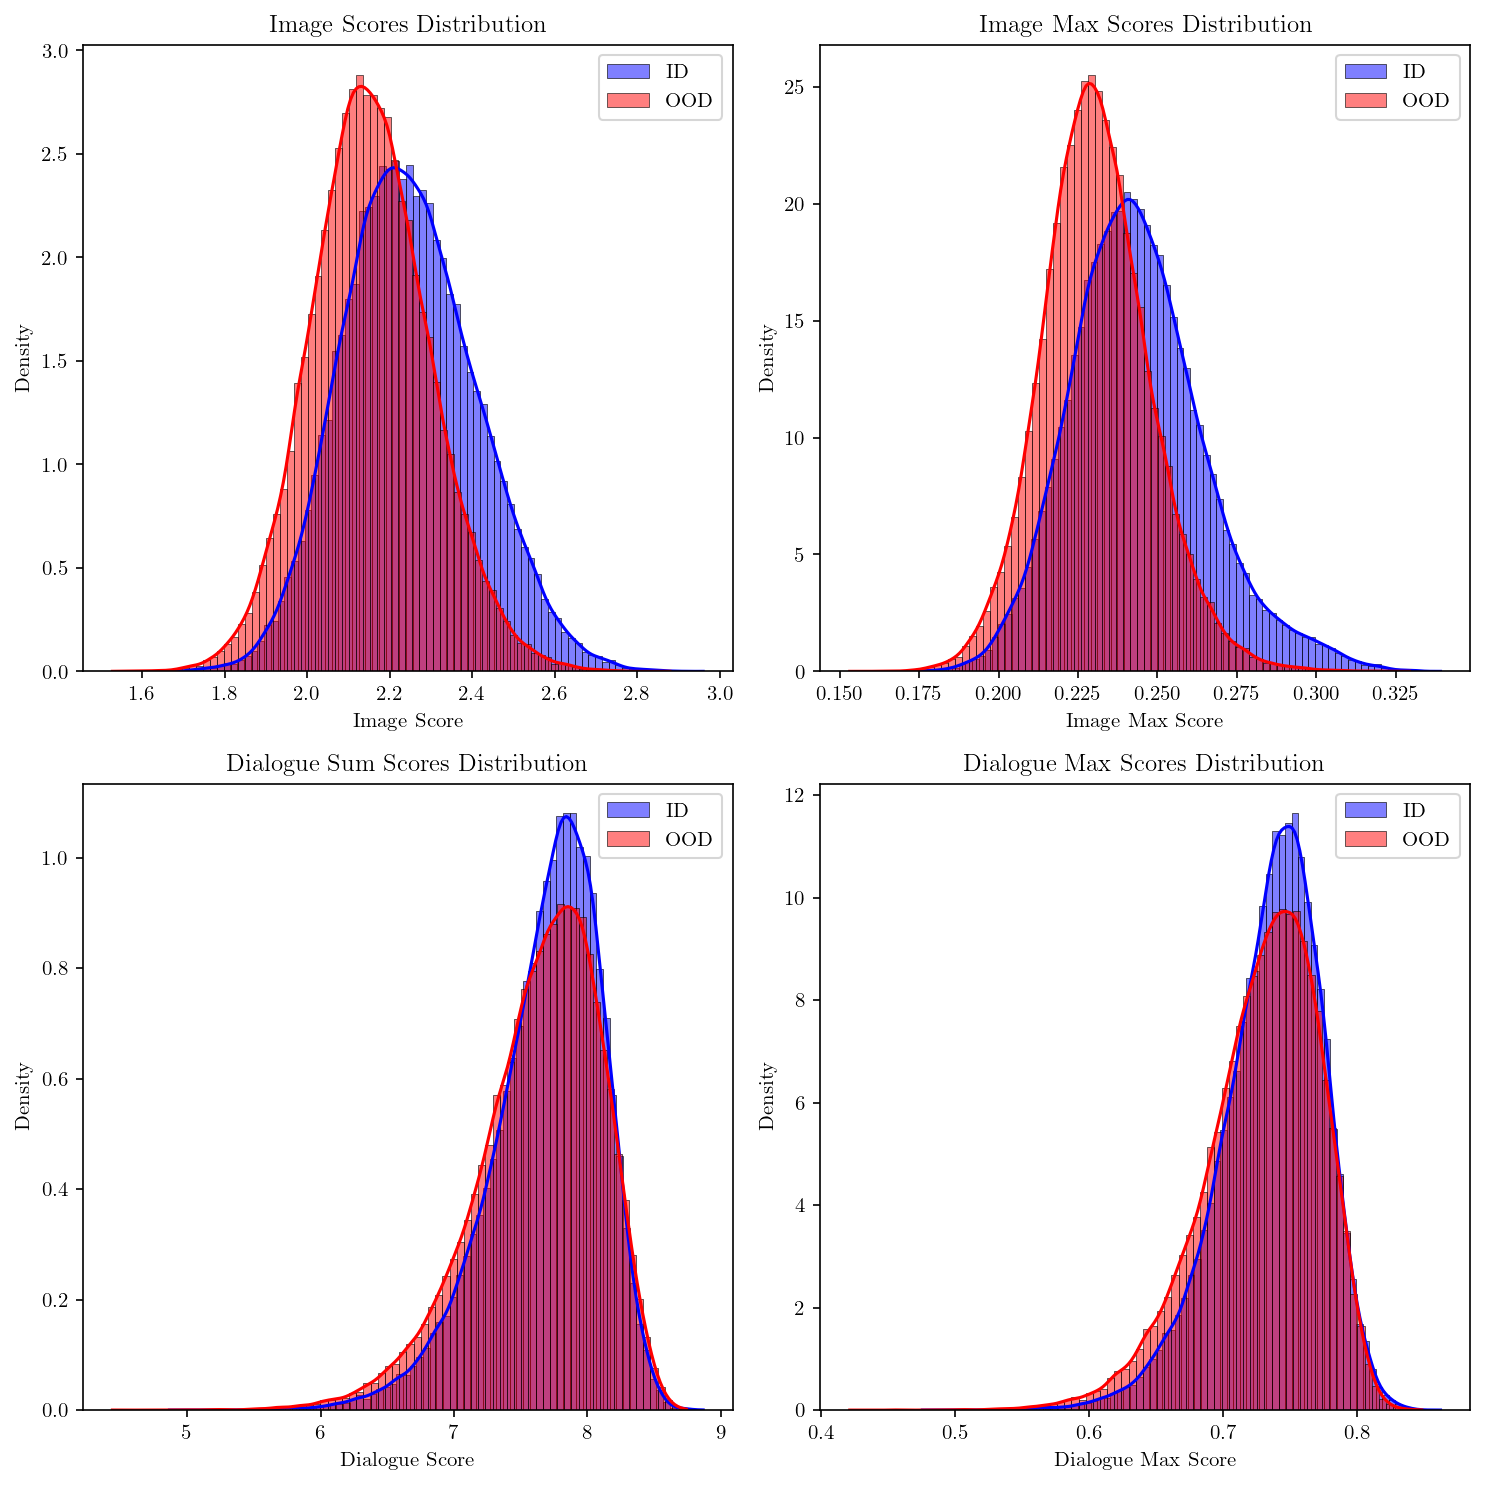

In [10]:
from utils import plot_figure
import importlib
importlib.reload(plot_figure)

plot_figure.plot_cosine(df_table, save_fig = False, save_format = 'pdf', dpi = 300)

<Axes: xlabel='image_text_similarity', ylabel='Count'>

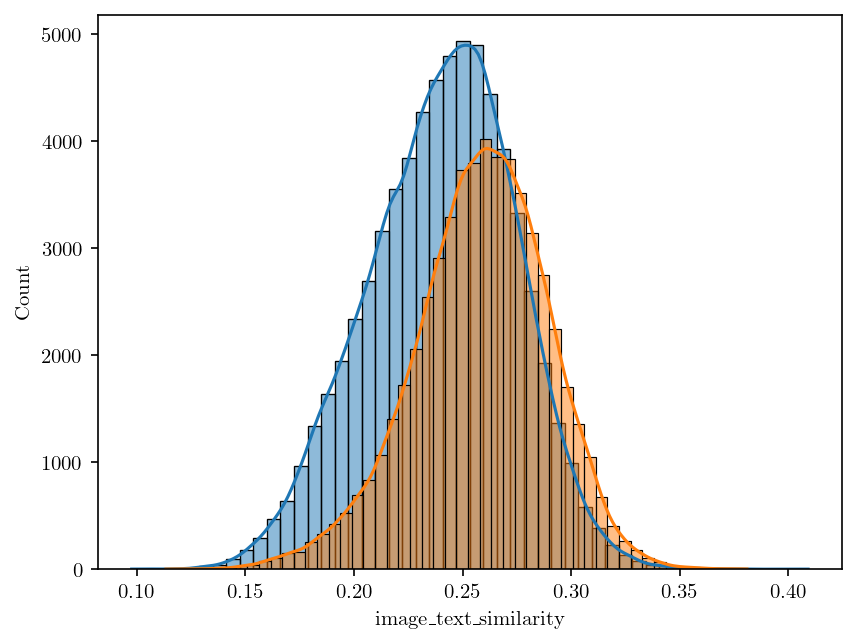

In [14]:
sns.histplot(df_table[df_table['OOD'] == 0]['image_text_similarity'], bins=50, kde=True)
sns.histplot(df_table[df_table['OOD'] == 1]['image_text_similarity'], bins=50, kde=True)

In [11]:
def image_text_similarity(row):
    a = row['dialogue_clip']
    b = row['image_clip']
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim
df_table['image_text_similarity'] = df_table.apply(image_text_similarity, axis=1)
df_table['overall_simialrity'] = (df_table['image_score_max'] + df_table['dialogue_score_max'])
df_table['overall_simialrity_sum'] = (df_table['image_score'] + df_table['dialogue_score'])
df_table['overall_simialrity_transform'] = 4 * df_table['overall_simialrity'] * df_table['image_text_similarity']
df_table['overall_simialrity_transform_sum'] = 4 * df_table['overall_simialrity_sum'] * df_table['image_text_similarity']

In [12]:
print('Image Max:', ev.fpr_evaluation(df_table['OOD'].values, df_table['image_score_max'].values, 0.95))
print('Image Sum:', ev.fpr_evaluation(df_table['OOD'].values, df_table['image_score'].values, 0.95))
print('Dialogue Max:', ev.fpr_evaluation(df_table['OOD'].values, df_table['dialogue_score_max'].values, 0.95))
print('Dialogue Sum:', ev.fpr_evaluation(df_table['OOD'].values, df_table['dialogue_score'].values, 0.95))
#print('Dialogue Segment Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment_max'].values, 0.95))
#print('Dialogue Segment Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment'].values, 0.95))
print("Overall Max:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity'].values, 0.95))
print("Overall Sum:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity_sum'].values, 0.95))
print("Overall Transform Max:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity_transform'].values, 0.95))
print("Overall Transform Sum:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity_transform_sum'].values, 0.95))


Image Max: 0.8792809244401868
Image Sum: 0.8668123578014609
Dialogue Max: 0.9134385103580409
Dialogue Sum: 0.9226439947311699
Overall Max: 0.8856723745659203
Overall Sum: 0.9047419470722069
Overall Transform Max: 0.81991677643396
Overall Transform Sum: 0.8294216261525565


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from models.DNN import model 

image_model_loader = model.model_loader(logger=logger,
                                  num_epochs=6,
                                  learning_rate=0.001,
                                  proportion = 0.8,
                                  seed = 20)


2024-05-18 21:42:15,844 - notebook_logger - INFO - Setting random seed: 20


In [16]:
dialogue_model_loader = model.model_loader(logger=logger,
                                    num_epochs=6,
                                    learning_rate=0.001,
                                    seed = 20)

2024-05-18 21:42:16,399 - notebook_logger - INFO - Setting random seed: 20


In [17]:
(
    df_ind_train, 
    df_test, 
    X_train_image, 
    X_test_image, 
    X_train_dialogue, 
    X_test_dialogue, 
    Y_train, 
    Y_test) = image_model_loader.create_dataset(data_loader, df_table, add_mismatch = True, mismatch_num = 15000)

df_test['image_text_similarity'] = df_test.apply(image_text_similarity, axis=1)

<Axes: xlabel='image_text_similarity', ylabel='Count'>

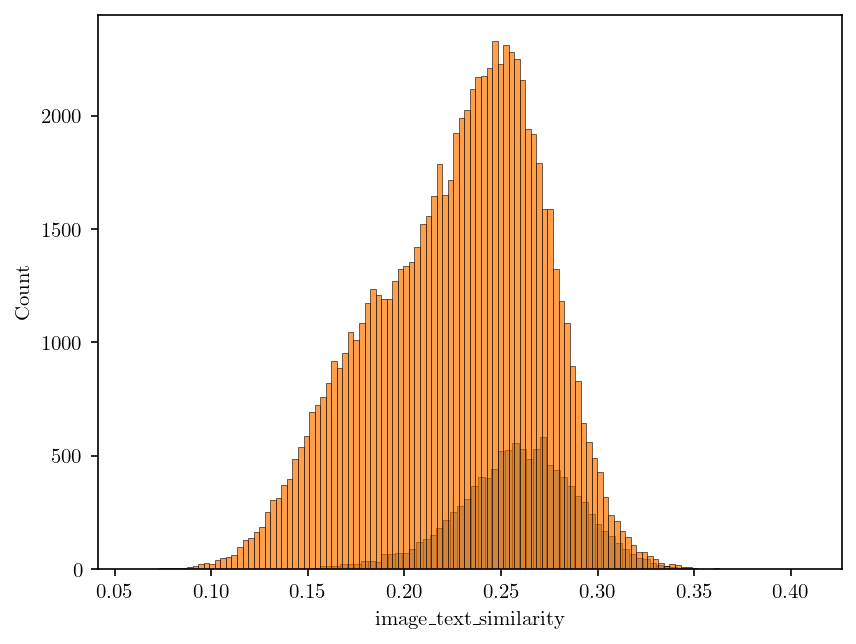

In [18]:
sns.histplot(df_test[df_test['OOD'] == 1]['image_text_similarity'])
sns.histplot(df_test[df_test['OOD'] == 0]['image_text_similarity'])

In [19]:
image_model_loader.train_model(X_train_image, Y_train, X_test_image, Y_test, ood_category = '_'.join(ood_category))

100%|██████████| 6/6 [00:56<00:00,  9.36s/it]
2024-05-18 21:43:52,206 - notebook_logger - INFO - Model saved at f:\Github\multimodal_ood\models\DNN\models\DNN\image_model_person_6_0.001.pth


In [20]:
dialogue_model_loader.train_model(X_train_dialogue, Y_train, X_test_dialogue, Y_test, ood_category = '_'.join(ood_category))

100%|██████████| 6/6 [00:56<00:00,  9.39s/it]
2024-05-18 21:44:48,580 - notebook_logger - INFO - Model saved at f:\Github\multimodal_ood\models\DNN\models\DNN\image_model_person_6_0.001.pth


In [21]:
score_type_list = ["mp", "energy", "logits", "msp"]

for score_type in score_type_list:
    image_score_sum, image_score_max = image_model_loader.evaluate_on_test(X_test_image, 
                                                        Y_test,
                                                        score_type=score_type,\
                                                        return_score=True)
    
    dialogue_score_sum, dialogue_score_max = dialogue_model_loader.evaluate_on_test(X_test_dialogue, 
                                                        Y_test,
                                                        score_type=score_type,\
                                                        return_score=True)
    
    df_test[f'{score_type}_sum_image'] = image_score_sum
    df_test[f'{score_type}_max_image'] = image_score_max
    df_test[f'{score_type}_sum_dialogue'] = dialogue_score_sum
    df_test[f'{score_type}_max_dialogue'] = dialogue_score_max
    df_test[f'{score_type}_max_image_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_max_image'] 
    df_test[f'{score_type}_max_dialogue_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_max_dialogue']
    df_test[f'{score_type}_sum_image_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_sum_image']
    df_test[f'{score_type}_sum_dialogue_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_sum_dialogue']

    df_test[f'{score_type}_overall_simialrity_max'] =  df_test[f'{score_type}_max_image_tranform'] + df_test[f'{score_type}_max_dialogue_tranform']
    if score_type in ["energy", "logits"]:
        df_test[f'{score_type}_overall_simialrity_sum'] = df_test[f'{score_type}_sum_image_tranform'] + df_test[f'{score_type}_sum_dialogue_tranform']

2024-05-18 21:44:51,156 - notebook_logger - INFO - Test Loss: 0.2402, Test Accuracy: 0.4499
2024-05-18 21:44:53,693 - notebook_logger - INFO - Test Loss: 0.4253, Test Accuracy: 0.2923
2024-05-18 21:44:56,490 - notebook_logger - INFO - Test Loss: 0.2402, Test Accuracy: 0.4499
2024-05-18 21:44:59,176 - notebook_logger - INFO - Test Loss: 0.4253, Test Accuracy: 0.2923
2024-05-18 21:45:01,682 - notebook_logger - INFO - Test Loss: 0.2402, Test Accuracy: 0.4499
2024-05-18 21:45:04,280 - notebook_logger - INFO - Test Loss: 0.4253, Test Accuracy: 0.2923
2024-05-18 21:45:06,796 - notebook_logger - INFO - Test Loss: 0.2402, Test Accuracy: 0.4499
2024-05-18 21:45:09,306 - notebook_logger - INFO - Test Loss: 0.4253, Test Accuracy: 0.2923


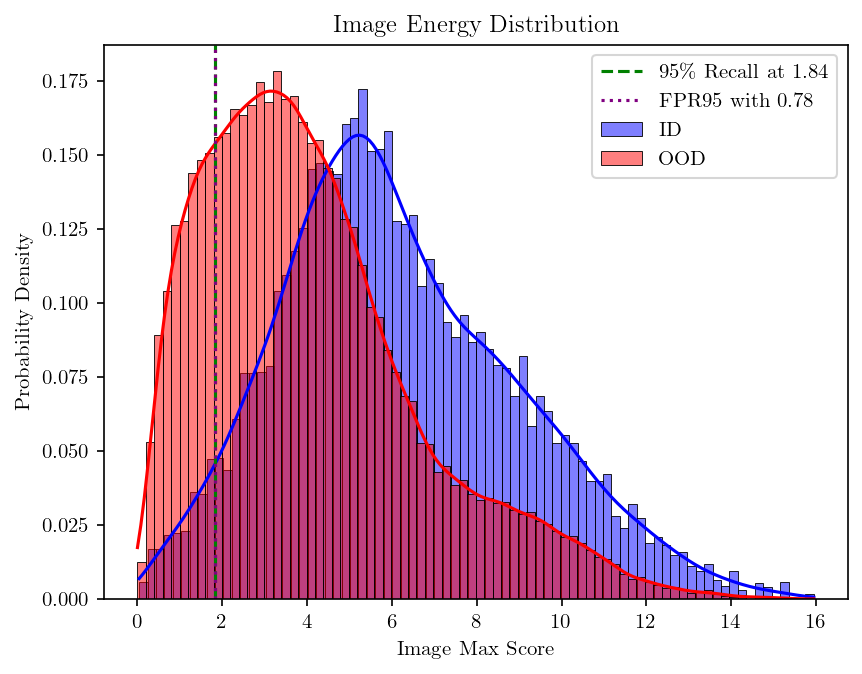

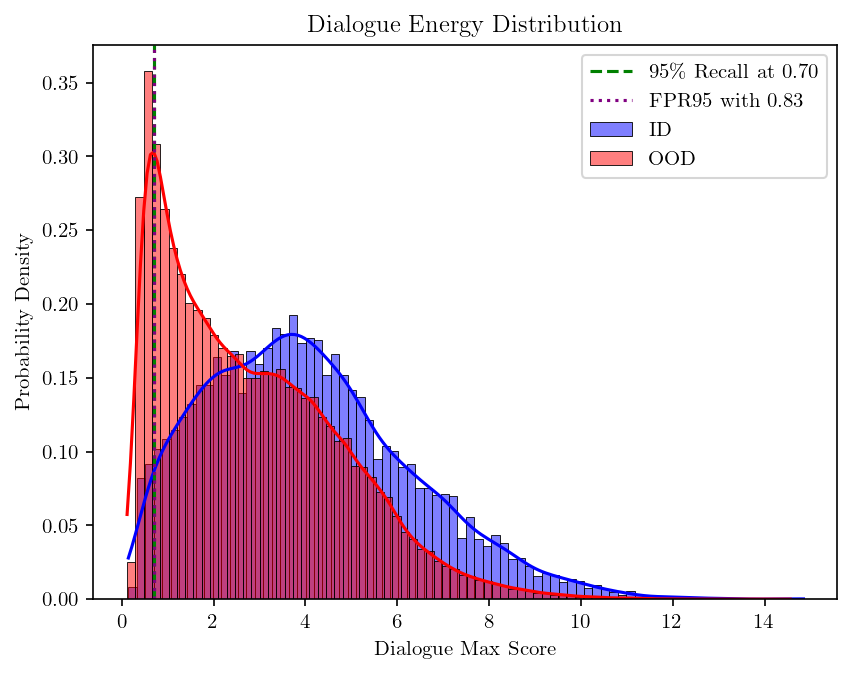

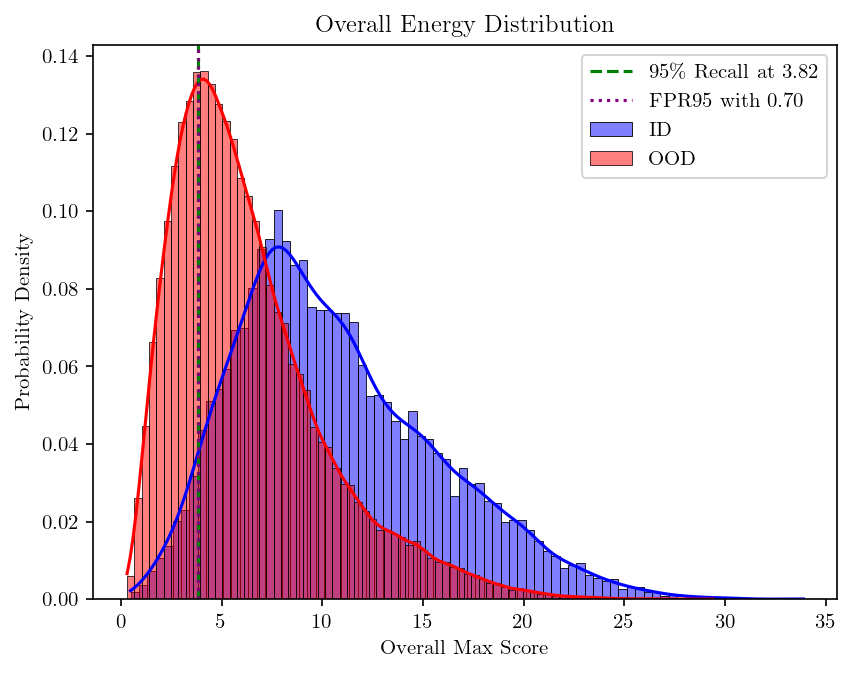

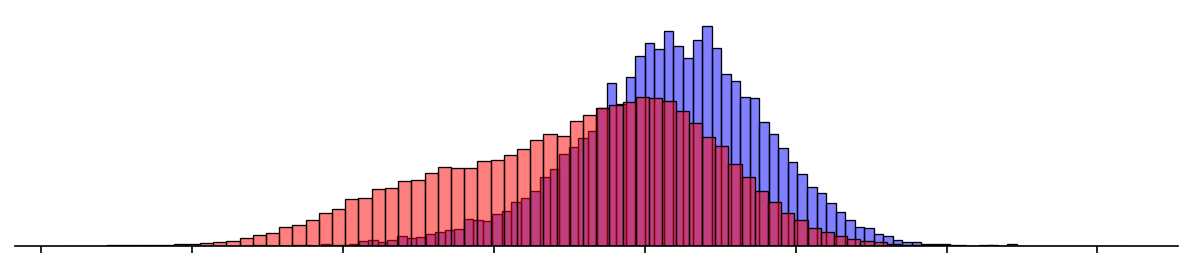

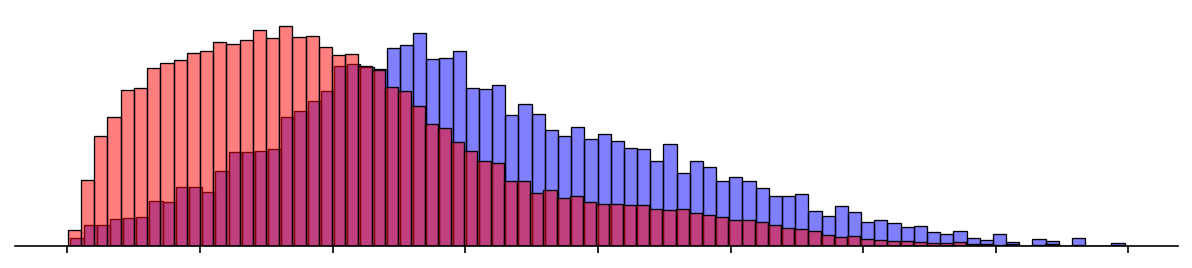

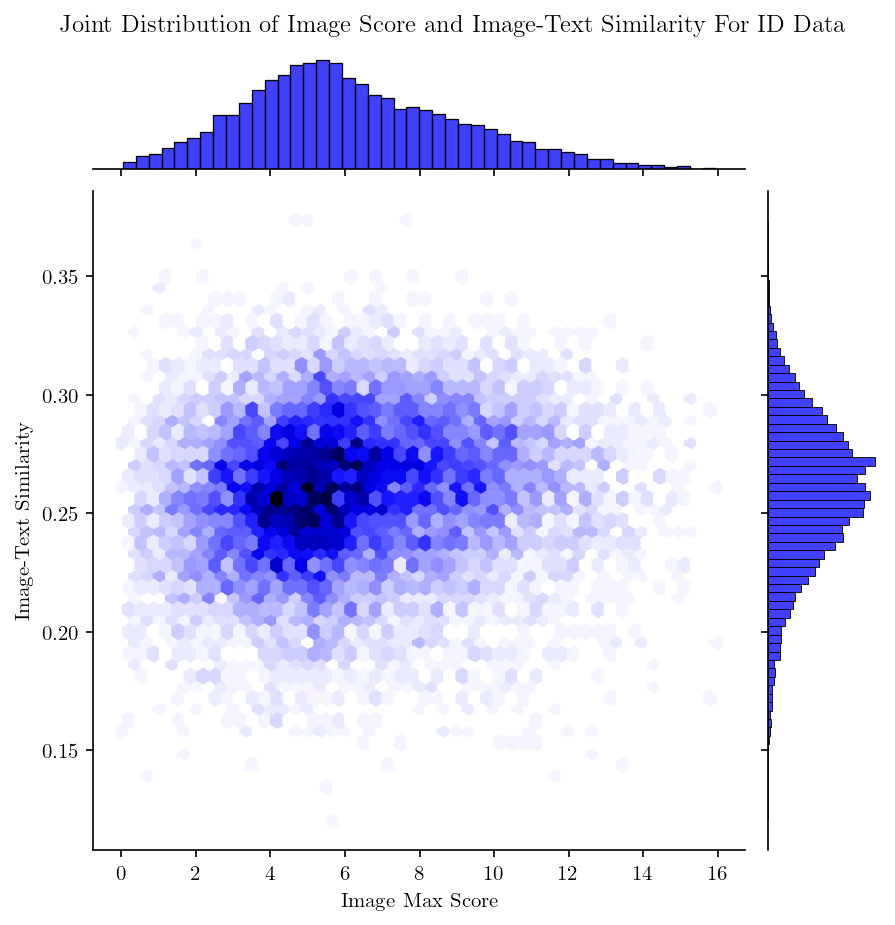

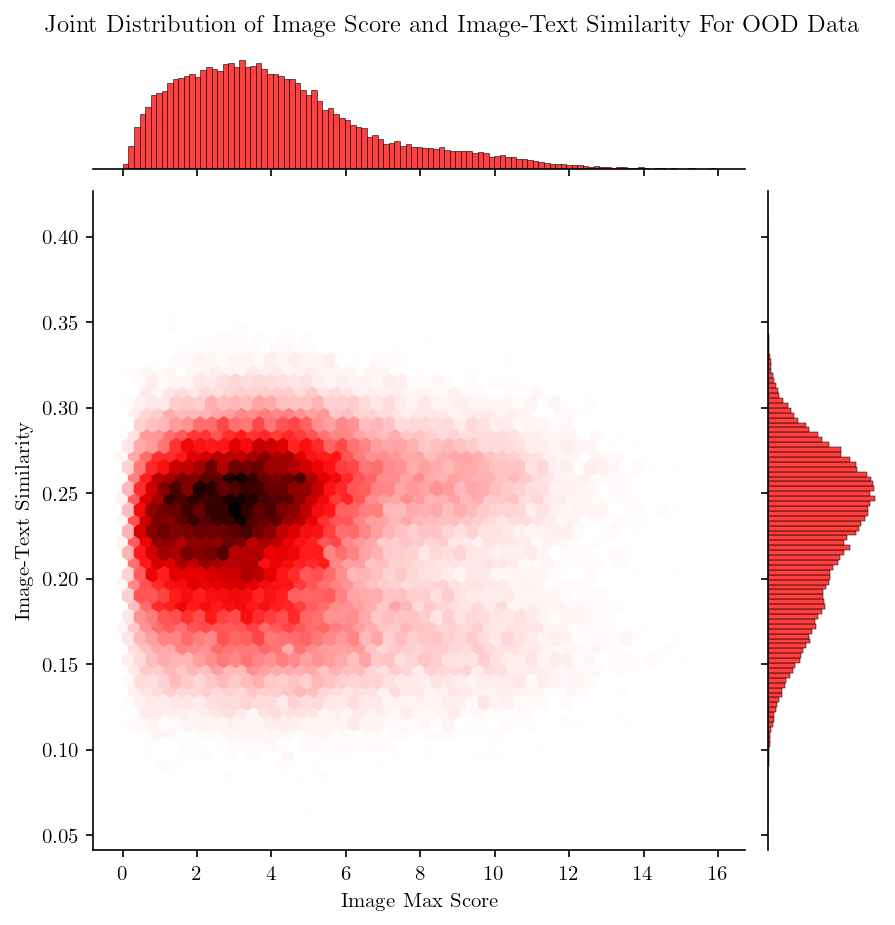

In [26]:
import importlib
importlib.reload(plot_figure)

score_type = "energy"
type = "max"
mode = "image"
fpr = 95

plot_figure.plot_score_distribution(df_test, score_type, type, mode="image", fpr=fpr)
plot_figure.plot_score_distribution(df_test, score_type, type, mode="dialogue", fpr=fpr)
plot_figure.plot_score_distribution(df_test, score_type, type, mode="overall", fpr=fpr)
#plot_figure.plot_kde_joint_distribution(df_test, score_type, type, mode)
plot_figure.plot_rough_distribution(df_test, 'image_text_similarity')
plot_figure.plot_rough_distribution(df_test, f'{score_type}_{type}_{mode}')
plot_figure.plot_joint_distribution(df_test, score_type, type, mode, id = 1, color = 'blue')
plot_figure.plot_joint_distribution(df_test, score_type, type, mode, id = 0, color = 'red')

In [27]:
# Initialize lists to store data
metrics = []
values = []
scores = [] 

def eval_dict(score):
    return {
        "FPR": lambda x: ev.fpr_evaluation(x['OOD'].values, x[score].values, 0.95),
        "AUROC": lambda x: ev.auroc_evaluation(x['OOD'].values, x[score].values),
        "AUPR": lambda x: ev.aupr_evaluation(x['OOD'].values, x[score].values)
    }

# Define the metrics and corresponding functions
metric_functions = {
    "Max Cosine": {
        "Image": eval_dict('image_score_max'),
        "Dialogue": eval_dict('dialogue_score_max'),
        "Overall": eval_dict('overall_simialrity')
    },
    "Sum Cosine": {
        "Image": eval_dict('image_score'),
        "Dialogue": eval_dict('dialogue_score'),
        "Overall": eval_dict('overall_simialrity_sum')
    },
    "Energy Sum": {
        "Image": eval_dict('energy_sum_image'),
        "Dialogue": eval_dict('energy_sum_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity_sum')
    },
    "Energy Max": {
        "Image": eval_dict('energy_max_image'),
        "Dialogue": eval_dict('energy_max_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity_max')
    },
    "MSP": {
        "Image": eval_dict('msp_max_image'),
        "Dialogue": eval_dict('msp_max_dialogue'),
        "Overall": eval_dict('msp_overall_simialrity_max')
    },
    "Max Prob": {
        "Image": eval_dict('mp_max_image'),
        "Dialogue": eval_dict('mp_max_dialogue'),
        "Overall": eval_dict('mp_overall_simialrity_max')
    },
    "Max Logits": {
        "Image": eval_dict('logits_max_image'),
        "Dialogue": eval_dict('logits_max_dialogue'),
        "Overall": eval_dict('logits_overall_simialrity_max')
    },
    "Sum Logits": {
        "Image": eval_dict('logits_sum_image'),
        "Dialogue": eval_dict('logits_sum_dialogue'),
        "Overall": eval_dict('logits_overall_simialrity_sum')
    }
}

# Loop through each metric and calculate values
for score, items in metric_functions.items():
    scores.extend([score] * len(items) * 3)
    for metric, funcs in items.items():
        metrics.extend([metric] * len(funcs))
        values.extend([func(df_test) for func in funcs.values()])

# Create DataFrame
df = pd.DataFrame({"Metric": metrics, "Value": values, "Score": scores})
df['Value'] = df['Value'].apply(lambda x: round(x, 3))
#df_grouped = df.groupby('Metric')['Value'].apply(list).reset_index()
result = df.groupby(['Metric', 'Score'])['Value'].agg(list).unstack().transpose()
result[['Image', 'Dialogue', 'Overall']]

Metric,Image,Dialogue,Overall
Score,,,
Energy Max,"[0.786, 0.719, 0.237]","[0.821, 0.667, 0.215]","[0.705, 0.77, 0.329]"
Energy Sum,"[0.819, 0.712, 0.23]","[0.855, 0.696, 0.234]","[0.694, 0.79, 0.351]"
MSP,"[0.865, 0.67, 0.239]","[0.849, 0.626, 0.202]","[0.732, 0.733, 0.252]"
Max Cosine,"[0.882, 0.671, 0.234]","[0.915, 0.538, 0.129]","[0.894, 0.604, 0.183]"
Max Logits,"[0.786, 0.719, 0.237]","[0.821, 0.667, 0.215]","[0.713, 0.768, 0.328]"
Max Prob,"[0.786, 0.719, 0.237]","[0.821, 0.667, 0.215]","[0.682, 0.759, 0.271]"
Sum Cosine,"[0.883, 0.653, 0.212]","[0.922, 0.528, 0.123]","[0.908, 0.578, 0.156]"
Sum Logits,"[0.994, 0.322, 0.083]","[0.988, 0.408, 0.097]","[0.999, 0.28, 0.077]"


## Results on OOD

# Without Mismatching Pair, Test ID instance 23233, Test OOD instance 6051


## Without image text similarity score
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.32, 0.952, 0.988]  |
| Energy Sum | [0.236, 0.964, 0.991] | [0.508, 0.935, 0.984] | [0.151, 0.974, 0.994] |
| MSP        | [0.894, 0.625, 0.873] | [0.919, 0.68, 0.905]  | [0.885, 0.657, 0.889] |
| Max Cosine | [0.877, 0.711, 0.905] | [0.971, 0.54, 0.835]  | [0.964, 0.579, 0.857] |
| Max Logits | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.331, 0.951, 0.988] |
| Max Prob   | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.507, 0.927, 0.982] |
| Sum Cosine | [0.94, 0.576, 0.84]   | [0.978, 0.494, 0.814] | [0.972, 0.51, 0.817]  |
| Sum Logits | [0.904, 0.762, 0.934] | [0.974, 0.758, 0.931] | [0.932, 0.788, 0.943] |

## With image text similarity score overall
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.346, 0.945, 0.986] |
| Energy Sum | [0.236, 0.964, 0.991] | [0.508, 0.935, 0.984] | [0.194, 0.97, 0.993]  |
| MSP        | [0.894, 0.625, 0.873] | [0.919, 0.68, 0.905]  | [0.908, 0.574, 0.846] |
| Max Cosine | [0.877, 0.711, 0.905] | [0.971, 0.54, 0.835]  | [0.964, 0.579, 0.857] |
| Max Logits | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.35, 0.945, 0.986]  |
| Max Prob   | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.731, 0.793, 0.934] |
| Sum Cosine | [0.94, 0.576, 0.84]   | [0.978, 0.494, 0.814] | [0.972, 0.51, 0.817]  |
| Sum Logits | [0.904, 0.762, 0.934] | [0.974, 0.758, 0.931] | [0.955, 0.764, 0.934] |

# With 5000 mismatching pairs, testing ID instance 23233, test OOD isntance 11051


## Without image text similarity
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.614, 0.758, 0.838] |
| Energy Sum | [0.546, 0.762, 0.821] | [0.698, 0.748, 0.819] | [0.522, 0.767, 0.843] |
| MSP        | [0.92, 0.57, 0.737]   | [0.932, 0.604, 0.762] | [0.921, 0.598, 0.773] |
| Max Cosine | [0.908, 0.618, 0.758] | [0.961, 0.523, 0.708] | [0.959, 0.544, 0.724] |
| Max Logits | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.619, 0.758, 0.839] |
| Max Prob   | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.707, 0.765, 0.848] |
| Sum Cosine | [0.945, 0.543, 0.712] | [0.965, 0.497, 0.693] | [0.963, 0.506, 0.695] |
| Sum Logits | [0.923, 0.65, 0.783]  | [0.963, 0.648, 0.782] | [0.953, 0.672, 0.814] |

## With imge text similarity score on overall 
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.598, 0.862, 0.932] |
| Energy Sum | [0.546, 0.762, 0.821] | [0.698, 0.748, 0.819] | [0.511, 0.872, 0.934] |
| MSP        | [0.92, 0.57, 0.737]   | [0.932, 0.604, 0.762] | [0.752, 0.723, 0.831] |
| Max Cosine | [0.908, 0.618, 0.758] | [0.961, 0.523, 0.708] | [0.959, 0.544, 0.724] |
| Max Logits | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.607, 0.86, 0.931]  |
| Max Prob   | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.569, 0.859, 0.924] |
| Sum Cosine | [0.945, 0.543, 0.712] | [0.965, 0.497, 0.693] | [0.963, 0.506, 0.695] |
| Sum Logits | [0.923, 0.65, 0.783]  | [0.963, 0.648, 0.782] | [0.975, 0.546, 0.709] |






